# Detection of meteor scatter pings in GRAVES recording

This notebook shows an algorithm for the detection of meteor scatter pings in a recording of GRAVES done on 2018-08-11, during the Perseids meteor shower.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import scipy.stats
import matplotlib.patches

The recording data we load is already preprocessed as FFT (waterfall) data. The data is power spectral density in dB units. The frequency resolution is 4kHz/256 = 15.625Hz and the time resolution is 256/4kHz = 64ms.

In [2]:
waterfall = np.load('/mnt/perseids2018/data.npz')['waterfall']
waterfall_linear = 10**(0.1*waterfall)
waterfall.shape

(88224, 256)

First we plot the average power spectral density. Note the GRAVES pings on the centre of the graph.

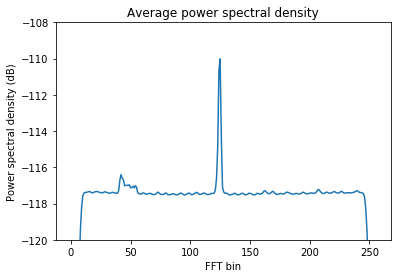

In [3]:
average_psd = 10*np.log10(np.average(waterfall_linear, axis = 0))
plt.plot(average_psd)
plt.title('Average power spectral density')
plt.ylabel('Power spectral density (dB)')
plt.xlabel('FFT bin')
plt.ylim([-120,-108]);

Our detection algorithm is based on the calculation of SNR. The signal power is computed over a certain number of FFT bins centred on the GRAVES frequency. We zoom in the graph to validate our selection.

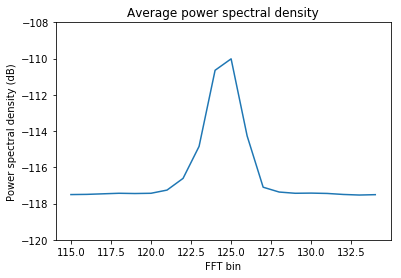

In [4]:
span = 10
centre = waterfall.shape[1]//2 - 3

signal_bins = np.arange(centre-span, centre+span)

plt.plot(signal_bins, average_psd[signal_bins])
plt.title('Average power spectral density')
plt.ylabel('Power spectral density (dB)')
plt.xlabel('FFT bin')
plt.ylim([-120,-108]);

To avoid the interference around bin 50, we measure signal plus noise over two disjoint intervals of bins.

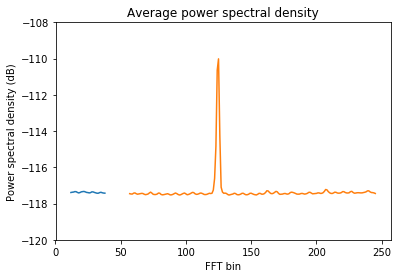

In [5]:
noise_bins_left = np.arange(12,39)
noise_bins_right = np.arange(57,246)
noise_bins = np.concatenate((noise_bins_left, noise_bins_right))

plt.plot(noise_bins_left, average_psd[noise_bins_left])
plt.plot(noise_bins_right, average_psd[noise_bins_right])
plt.title('Average power spectral density')
plt.ylabel('Power spectral density (dB)')
plt.xlabel('FFT bin')
plt.ylim([-120,-108]);

We now calculate the SNR in dB units usin the signal bins and noise bins chosen above.

In [6]:
signal = np.sum(waterfall_linear[:,signal_bins], axis=1)
signal_plus_noise = np.sum(waterfall_linear[:,noise_bins], axis=1)
snr = 10*np.log10(signal/(signal_plus_noise-signal))

We plot the SNR versus time. We see strong spikes corresponding to meteor scatter pings.

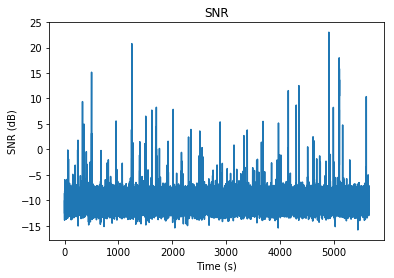

In [7]:
time = np.arange(waterfall.shape[0]) * 256 / 4e3
plt.plot(time, snr)
plt.title('SNR')
plt.xlabel('Time (s)')
plt.ylabel('SNR (dB)');

Pings will be detected according as to whether the SNR is above a certain threshold. For chosing the threshold, it is useful to have a look the distribution of the SNR.

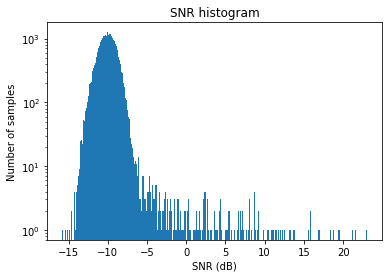

In [8]:
plt.hist(snr, bins=1000)
plt.yscale('log')
plt.title('SNR histogram')
plt.ylabel('Number of samples')
plt.xlabel('SNR (dB)');

To chose the threshold we set a desired probability of false acquisition and obtain the threshold from there. In this case the null hypothesis corresponds to no meteor scatter signal being present. Thus, under the null hypothesis we assume that all the signal and noise bins are independent random variables whose distribution is a chi-squared with 2 degrees of freedom.

We denote by $n$ the number of noise bins and by $k$ the number of signal bins. Then the noise and signal power are distributed as chi-squared distributions with $2n$ and $2k$ degrees of freedom respectively.

The SNR is the quotient of two chi-squared distributions, and so it is distributed as $k/n$ times an F-distribution with parameters $2k$ and $2n$.

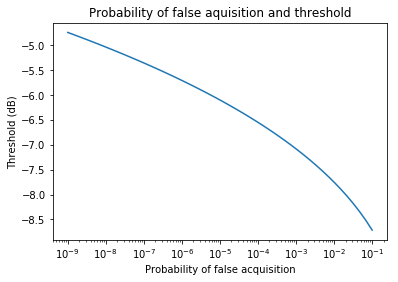

In [9]:
k = signal_bins.size
n = noise_bins.size - signal_bins.size

def threshold(pfa):
    return 10*np.log10(k/n*scipy.stats.f.ppf(1-pfa, dfn=2*k, dfd=2*n))

pfa = np.logspace(-9,-1)
plt.semilogx(pfa, threshold(pfa))
plt.title('Probability of false aquisition and threshold')
plt.ylabel('Threshold (dB)')
plt.xlabel('Probability of false acquisition');

Since there are roughly $10^5$ samples, we choose a probability of false acqusition of $10^{-7}$.

In [10]:
alpha = threshold(1e-6)
alpha

-5.7090191434975912

We now get the number of detections.

In [11]:
detections = np.where(snr > alpha)[0]
detections.size

762

Since a single ping is detected in many samples, we need to apply a clustering algorithm to separate individual pings. Also, since not all the samples in a ping are above the threshold, we apply a lower threshold to extend and cluster detection over neighbouring samples.

In [12]:
beta = alpha - 1
detections2 = np.where(snr > beta)[0]
detections2.size

1021

The clustering algorithm works by setting a certain allowed jump and clustering all detections that can be reached doing jumps of size smaller than this maximum jump.

In [13]:
cluster_jump_seconds = 2
cluster_jump = cluster_jump_seconds * 4e3 / 250
marks = list()
right_mark = -np.inf
while np.any(detections > right_mark):
    left_mark = detections[detections > right_mark][0]
    right_mark = left_mark
    while np.any(detections2[detections2> right_mark]) and \
        detections2[detections2 > right_mark][0] < right_mark + cluster_jump:
        right_mark = detections2[detections2 > right_mark][0]
    marks.append((left_mark, right_mark))
len(marks)

111

Now we plot each of the detections to a file.

In [16]:
margin_seconds = 5
margin = margin_seconds * 4e3 / 250
for j,m in enumerate(marks):
    l = m[0]
    r = m[1]
    start = int(np.clip(l - margin, 0, waterfall.shape[0]-1))
    end = int(np.clip(r + margin, 0, waterfall.shape[0]-1))
    plt.imsave('/tmp/ping_{:0{size}d}'.format(j, size=int(np.ceil(np.log10(len(marks))))),\
               waterfall[start:end,::-1].T, vmin = -120, vmax = -90);